In [1]:
import statsmodels.api as sm      # 时序分解
from sklearn.preprocessing import MinMaxScaler # 数据归一化
from numpy import array
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

import tensorflow as tf

import tensorflow.keras as keras
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Bidirectional

from sklearn.metrics import mean_squared_error
from math import sqrt,exp,log
from sklearn import metrics,tree # 计算指标
import random
from algorithm_2 import algorithm_2

D:\adconda\envs\tensorflow37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\adconda\envs\tensorflow37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\adconda\envs\tensorflow37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\adconda\envs\tensorflow37\lib\site-packages\tensorflow\python\framework\dtypes.py:519: Futu

In [2]:
RATE = 0.7     # 训练集，测试集比例(7:3)
N_timestamp=24   # 每24个数据（一天）预测下一个（一小时）
X_dim = 10        # 六个维度特征：PM2.5 PM10 CO2....
Epoch_WL = 10    #弱学习器迭代次数
Epoch_SL = 50    #强学习器迭代次数
Batch_Size = 64     # 批训练大小  

Loss = 'mean_absolute_error'

optimizer = keras.optimizers.Adam(0.001)


In [3]:
# 设置随机数种子，使结果可复现
my_seed = 23
np.random.seed(my_seed)
random.seed(my_seed)
tf.set_random_seed(my_seed)


          No  year  month  day  hour  PM2.5  PM10   SO2   NO2     CO    O3  \
0          1  2013      3    1     0    4.0   4.0   4.0   7.0  300.0  77.0   
1          2  2013      3    1     1    8.0   8.0   4.0   7.0  300.0  77.0   
2          3  2013      3    1     2    7.0   7.0   5.0  10.0  300.0  73.0   
3          4  2013      3    1     3    6.0   6.0  11.0  11.0  300.0  72.0   
4          5  2013      3    1     4    3.0   3.0  12.0  12.0  300.0  72.0   
...      ...   ...    ...  ...   ...    ...   ...   ...   ...    ...   ...   
35059  35060  2017      2   28    19   12.0  29.0   5.0  35.0  400.0  95.0   
35060  35061  2017      2   28    20   13.0  37.0   7.0  45.0  500.0  81.0   
35061  35062  2017      2   28    21   16.0  37.0  10.0  66.0  700.0  58.0   
35062  35063  2017      2   28    22   21.0  44.0  12.0  87.0  700.0  35.0   
35063  35064  2017      2   28    23   19.0  31.0  10.0  79.0  600.0  42.0   

       TEMP    PRES  DEWP  RAIN   wd  WSPM       station  
0   

<AxesSubplot:>

<Figure size 21600x1440 with 0 Axes>

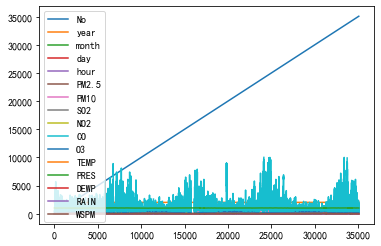

In [4]:
# 导入数据 共一列数据, 默认索引
#data = pd.read_csv('data_fillna.csv', usecols=['0'], squeeze=True)
data = pd.read_csv('PRSA_Data_Aotizhongxin_20130301-20170228.csv')
print(data)
plt.figure(figsize=(300, 20))
data.plot() 

In [5]:
#引用数据
len(data)
df = pd.DataFrame(data, columns=["PM2.5", "PM10", "SO2", "NO2", "CO", "O3", "TEMP", "PRES", "DEWP", "RAIN"])
print(df)
data = np.array(df)

# 空值处理
for i in range(len(data)):
    for j in range(len(data[i])):
        if np.isnan(data[i, j]):
            data[i, j] = data[i - 1, j]

print(np.isnan(data))
print(np.isnan(data).sum())
print(data)


       PM2.5  PM10   SO2   NO2     CO    O3  TEMP    PRES  DEWP  RAIN
0        4.0   4.0   4.0   7.0  300.0  77.0  -0.7  1023.0 -18.8   0.0
1        8.0   8.0   4.0   7.0  300.0  77.0  -1.1  1023.2 -18.2   0.0
2        7.0   7.0   5.0  10.0  300.0  73.0  -1.1  1023.5 -18.2   0.0
3        6.0   6.0  11.0  11.0  300.0  72.0  -1.4  1024.5 -19.4   0.0
4        3.0   3.0  12.0  12.0  300.0  72.0  -2.0  1025.2 -19.5   0.0
...      ...   ...   ...   ...    ...   ...   ...     ...   ...   ...
35059   12.0  29.0   5.0  35.0  400.0  95.0  12.5  1013.5 -16.2   0.0
35060   13.0  37.0   7.0  45.0  500.0  81.0  11.6  1013.6 -15.1   0.0
35061   16.0  37.0  10.0  66.0  700.0  58.0  10.8  1014.2 -13.3   0.0
35062   21.0  44.0  12.0  87.0  700.0  35.0  10.5  1014.4 -12.9   0.0
35063   19.0  31.0  10.0  79.0  600.0  42.0   8.6  1014.1 -15.9   0.0

[35064 rows x 10 columns]
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...

In [6]:
# 数据集分组
datas = []

#分组个数
num_data_set = 10


length = int(len(data)/num_data_set)
for i in range(num_data_set - 1):
    datas.append(data[i*length:(i+1)*length])
datas.append(data[(num_data_set - 1)*length:])

print(datas)
print(np.shape(datas[0])[0])
print(np.shape(datas[0])[1])


[array([[   4. ,    4. ,    4. , ..., 1023. ,  -18.8,    0. ],
       [   8. ,    8. ,    4. , ..., 1023.2,  -18.2,    0. ],
       [   7. ,    7. ,    5. , ..., 1023.5,  -18.2,    0. ],
       ...,
       [  20. ,   49. ,    9. , ...,  995.5,   19.2,    0. ],
       [  22. ,   70. ,   10. , ...,  995.5,   19.1,    0. ],
       [  22. ,   70. ,    8. , ...,  995.6,   20.1,    0. ]]), array([[  17. ,   40. ,    8. , ...,  995.4,   19.4,    0. ],
       [  18. ,   52. ,    5. , ...,  995.3,   19.1,    0. ],
       [  21. ,   49. ,    6. , ...,  996.1,   18.4,    0. ],
       ...,
       [  11. ,    7. ,   14. , ..., 1030.4,  -17.7,    0. ],
       [   9. ,    6. ,   12. , ..., 1030.2,  -17.8,    0. ],
       [  11. ,   10. ,    9. , ..., 1029.8,  -17.2,    0. ]]), array([[  11. ,   10. ,    9. , ..., 1029.4,  -16.7,    0. ],
       [  10. ,    6. ,   16. , ..., 1029.2,  -16.9,    0. ],
       [  12. ,    8. ,   19. , ..., 1029. ,  -17.7,    0. ],
       ...,
       [  43. ,  102. ,   14.

In [7]:
data = datas[0]
 

In [8]:
train_set = data[:int(len(data)*RATE),:] 
test_set = data[int(len(data)*RATE):,:]
predict_al2 = algorithm_2(train_old, train_new, label_old, label_new, S_test, weak_learner, N,predict)

In [9]:
def data_split(sequence, n_timestamp):   # 
    # 取前 n_timestamp 天的数据为 X；n_timestamp+1天数据为 Y。
    X = []
    y = []

    for i in range(len(sequence)):
        end_ix = i + n_timestamp

        if end_ix > len(sequence) - 1:
            break

        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix,0]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [10]:
#数据归一化处理

sc  = MinMaxScaler(feature_range=(0, 1))
train_set_scaled = sc.fit_transform(train_set)
test_set_scaled  = sc.transform(test_set) 
#print(train_set_scaled)
#print(test_set_scaled)

#训练集输入输出
X_train, y_train = data_split(train_set_scaled,N_timestamp)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_dim)
X_test, y_test = data_split(test_set_scaled,N_timestamp)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_dim)


In [14]:
#sample 
print(X_train.shape[0])

2430


In [11]:
# 画图 Loss, result
def plot_loss(history):
    plt.plot(history.history['loss']    , label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
def plot_load(model, X_test, y_test, scaler=None, figsize=(60,10)):
    predicted_load = model.predict(X_test)                        # 测试集输入模型进行预测
    if scaler:
        predicted_load = scaler.inverse_transform(predicted_load)  # 对预测数据还原---从（0，1）反归一化到原始范围
        real_load      = scaler.inverse_transform(y_test)# 对真实数据还原---从（0，1）反归一化到原始范围
    else:
        real_load = y_test

    plt.figure(figsize=figsize)
    # 画出真实数据和预测数据的对比曲线
    plt.plot(real_load, color='red', label='Load')
    plt.plot(predicted_load, color='blue', label='Predicted Load')
    plt.title('R N N')
    plt.xlabel('Time')
    plt.ylabel('load')
    plt.legend()
    plt.show()

    MSE   = metrics.mean_squared_error(real_load, predicted_load)
    RMSE  = metrics.mean_squared_error(real_load, predicted_load)**0.5
    MAE   = metrics.mean_absolute_error(real_load, predicted_load)
    R2    = metrics.r2_score(real_load, predicted_load)
    EV    = metrics.explained_variance_score(real_load,predicted_load)   #新添加EV

    print("EV", EV)
    print("MSE:", MSE)
    print("RMSE:", RMSE)
    print("MAE:", MAE)
    print("R2:", R2)
    
    return real_load, predicted_load

In [12]:
# 构建神经网络模型LSTM
# 输入层
inputs = Input((N_timestamp, X_dim), name='inputs')

# LSTM 
# 全连接层
#LSTM_1 = LSTM(units=100, activation='relu', dropout=0.1)(inputs)
#dense_2 = Dense(units=50, activation='relu')(LSTM_1)


# 双向 LSTM
Bi_LSTM_1 = Bidirectional(LSTM(units = 50, activation='relu',return_sequences= True, dropout = 0.1))(inputs)
Bi_LSTM_2 = Bidirectional(LSTM(units = 50, activation='relu', dropout = 0.1))(Bi_LSTM_1)
dense_1 = Dense(units=50, activation='relu')(Bi_LSTM_2)
output = Dense(units=1, activation='relu')(dense_1)


# 构造一个新模型
model_1 = Model(inputs=inputs, outputs= output)
print(model_1.summary())
# # 编译
model_1.compile(optimizer=optimizer, loss=Loss)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 24, 10)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 24, 100)           24400     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               60400     
___________________________________________________

In [13]:
history_1 = model_1.fit(X_train,
                        y_train,
                        epochs = Epoch_WL, batch_size = Batch_Size, validation_split = 0.2)#

Train on 1944 samples, validate on 486 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
1944/1944 [==============================] - 3s 2ms/sample - loss: 0.0701 - val_loss: 0.0441
Epoch 2/10
1944/1944 [==============================] - 1s 386us/sample - loss: 0.0477 - val_loss: 0.0458
Epoch 3/10
1944/1944 [==============================] - 1s 391us/sample - loss: 0.0444 - val_loss: 0.0386
Epoch 4/10
1944/1944 [==============================] - 1s 386us/sample - loss: 0.0404 - val_loss: 0.0330
Epoch 5/10
1944/1944 [==============================] - 1s 405us/sample - loss: 0.0378 - val_loss: 0.0286
Epoch 6/10
1944/1944 [==============================] - 1s 386us/sample - loss: 0.0364 - val_loss: 0.0430
Epoch 7/10
1944/1944 [==============================] - 1s 405us/sample - loss: 0.0365 - val_loss: 0.0274
Epoch 8/10
1944/1944 [==============================] - 1s 391us/sample - loss: 0.0335 - val_loss: 0.0254
Epoch 9/10
19

In [ ]:
#模型保存


In [28]:
history_2 = model_1.fit(X_train,
                        y_train,
                        epochs = Epoch_WL, batch_size = Batch_Size, validation_split = 0.2)#

NameError: name 'model_1' is not defined

In [1]:
plot_loss(history_1)

NameError: name 'plot_loss' is not defined

In [27]:
#保存模型
model_save_path = "model_file_path.h5"

In [ ]:
history_1.shape

In [ ]:
#算法一
#predicted表示n个弱学习器对数据集第n+1的预测结果
#y_test表示第n+1个数据集的实际值
def algorithm_1(predicted,y_test): 
    #样本大小
    sample_size = y_test.shape[0]
    #初始化新数据集中的样本权重
    w = np.zeros([sample_size])
    w[:] = 1 / sample_size
    #初始化a_k
    a_k_all = []
    #初始化a_k_final
    a_k_final = []
    
    #对每一个弱学习器使用新数据集作为输入来输出预测
    for i in range(len(predicted)):
        E_k_max = 0
        E_k = np.zeros(sample_size)
        e_k = np.zeros(sample_size)
        
        
        for j in range(sample_size):
        #计算最大误差率数据集
            E_k[j] = abs(y_test[j,0] - predicted[i][j,0])
            
        E_k_max = np.max(E_k)
         #计算相关误差   
        for j in range(sample_size):
            e_k[j] = 1 - exp(abs(y_test[j,0] - predicted[i][j,0]))
            
        #计算回归误差
        regression_error_rate = np.sum(w * e_k)
        #计算标准误差率
        beta_k = regression_error_rate / ( 1 - regression_error_rate)
        
        #计算弱学习器比率
        a_k = 1/2 * log(1 / beta_k)
        a_k_all.append(a_k)
        #计算每个弱学习器的最终比率
    for a_k in a_k_all:
        a_k_final.append(a_k / np.sum(a_k_all))
        
    return a_k_final

#算法一使用时须在外部调用保存的模型，使用函数返回的a_k_final列表生成强学习器

    
       

In [ ]:
# -*- coding: utf-8 -*-
"""
@Copyright (C) 2022 mewhaku . All Rights Reserved
@Time ： 2022/8/8 11:19
@Author ： mewhaku
@File ：vfkmm.py
@IDE ：PyCharm
"""
import numpy as np
from sklearn import tree


# 算法二
# H 测试样本分类结果
# train_old 原训练样本 np数组
# train_new 辅助训练样本
# label_old 原训练样本标签
# label_new 辅助训练样本标签
# 使用老数据集训练的弱学习器weak_learner
# S_Test  测试样本
# N 迭代次数
def algorithm_2(train_old, train_new, label_old, label_new, S_test, weak_learner, N):
    train_data = np.concatenate((train_new, train_old), axis=0)
    train_label = np.concatenate((label_new, label_old), axis=0)

    # 赋值训练集的行数
    row_new = train_new.shape[0]
    row_old = train_old.shape[0]
    row_T = S_test.shape[0]

    test_data = np.concatenate((train_data, S_test), axis=0)

    # 初始化权重
    #缺少veryfastKMM
    #合并数据集train_old U train_new
    beta = train_new.shape[0]
    max_beta = train_old.shape[0]
    # beta 和 max_beta由veryfastKMM得到
    weight_1 = beta
    weight_2 = np.max(beta)
    weights = np.concatenate((weight_1, weight_2), axis=0)

    # 设置rho值 #
    rho = 1 / (1 + np.sqrt(2 * np.log(row_new / N)))

    # 存储每次迭代的标签和bata值
    bata_T = np.zeros([1, N])
    result_label = np.ones([row_new + row_old + row_T, N])

    predict = np.zeros([row_T])

    print('params initial finished.')
    train_data = np.asarray(train_data, order='C')
    train_label = np.asarray(train_label, order='C')
    test_data = np.asarray(test_data, order='C')

    for i in range(N):
        P = calculate_P(weights, train_label)

        result_label[:, i] = train_classify(train_data, train_label,
                                            test_data, P)
        print('result,', result_label[:, i], row_new, row_old, i, result_label.shape)

        error_rate = calculate_error_rate(label_old, result_label[row_new:row_new + row_old, i],
                                          weights[row_new:row_new + row_old, :])
        print('Error rate:', error_rate)
        
        if error_rate > 0.5:
            error_rate = 0.5
        if error_rate == 0:
            N = i
            break  # 防止过拟合
            # error_rate = 0.001
        
        #计算bete_t
        bata_T[0, i] = error_rate / (1 - error_rate)
        
        #权重更新
        # 调整源域样本权重
        for j in range(row_old):
            weights[row_new + j] = weights[row_new + j] * np.power(bata_T[0, i],
                                                               (-np.abs(result_label[row_new + j, i] - label_old[j])))

        # 调整辅域样本权重
        for j in range(row_new):
            weights[j] = weights[j] * np.power(rho, np.abs(result_label[j, i] - label_new[j]))
    # print bata_T
    for i in range(row_T):
        # 跳过训练数据的标签
        left = np.sum(
            result_label[row_new + row_old + i, int(np.ceil(N / 2)):N] * np.log(1 / bata_T[0, int(np.ceil(N / 2)):N]))
        right = 0.5 * np.sum(np.log(1 / bata_T[0, int(np.ceil(N / 2)):N]))

        if left >= right:
            predict[i] = 1
        else:
            predict[i] = 0
            # print left, right, predict[i]

    return predict

#计算p_t
def calculate_P(weights, label):
    total = np.sum(weights)
    return np.asarray(weights / total, order='C')

#训练分类器
def train_classify(trans_data, trans_label, test_data, P):
    clf = tree.DecisionTreeClassifier(criterion="gini", max_features="log2", splitter="random")
    clf.fit(trans_data, trans_label, sample_weight=P[:, 0])
    return clf.predict(test_data)

#输入用旧数据集训练的弱学习器
def calculate_error_rate(row_new, y_test, predicted, weight):
    E_k_max = 0
    E_k = np.zeros(sample_size)
    e_k = np.zeros(sample_size)
    for j in range(row_new):
        E_k[j] = abs(y_test[j,0] - predicted[j,0])
            
    E_k_max = np.max(E_k)
    
    for j in range(row_new):
        e_i[j] = 1 - exp(abs(y_test[j,0] - predicted[j,0]))
    regression_error_rate = np.sum(weight * e_i)
    return regression_error_rate


    